In [1]:
import os
import pandas as pd
import numpy as np
from scipy.stats import sem, mannwhitneyu, spearmanr
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
import string
import statsmodels.api as sm
from datetime import datetime, timedelta
import copy

In [2]:
os.makedirs("fig", exist_ok=True)

In [4]:
df_single = pd.read_csv("data/one_screen.csv")
df_single['date'] = pd.to_datetime(df_single['date'] + df_single['time'], 
                                   format="%d/%m/%Y%I:%M:%S%p")
df_single.rename(columns={"date": "datetime"}, inplace=True)
df_single.drop("time", inplace=True, axis=1)
df_single.sort_values(by="datetime", inplace=True)
df_single.reset_index(inplace=True, drop=True)
first_date = df_single.datetime.sort_values().iloc[0] # .date()
df_single['day'] = df_single.datetime.apply(lambda x: x - first_date).dt.days
df_single

,datetime,seconds,day
0,2016-10-05 19:45:45,3.08,0
1,2016-10-05 19:46:04,3.11,0
2,2016-10-05 19:46:14,6.30,0
3,2016-10-05 19:46:22,12.68,0
4,2016-10-05 19:47:09,47.89,0
...,...,...,...
493,2016-10-12 21:46:17,6.33,7
494,2016-10-12 21:46:50,3.11,7
495,2016-10-13 03:38:57,3.13,7
496,2016-10-13 03:53:10,12.71,7


In [5]:
n_days_single = df_single.day.max() + 1

SINGLE_total_interaction_time_per_day = np.zeros(n_days_single)
series = df_single.groupby(df_single.day)["seconds"].sum()
SINGLE_total_interaction_time_per_day[series.index] = series.to_numpy()

SINGLE_average_interaction_time_per_day = np.zeros(n_days_single)
series = df_single.groupby(df_single.day)["seconds"].mean()
SINGLE_average_interaction_time_per_day[series.index] = series.to_numpy()

SINGLE_number_interaction_per_day = np.zeros(n_days_single)
series = df_single.groupby(df_single.day)["seconds"].count()
SINGLE_number_interaction_per_day[series.index] = series.to_numpy()

In [6]:
df = pd.read_csv("data/data.csv")
df = df.drop(df[df.time == "/"].index)
df = df.drop(df[df.video == "/"].index)
df = df.dropna()
df['date'] = pd.to_datetime(df['date'].apply(str)+' '+ df['time'], format="%d/%m/%Y %H:%M:%S")
df.rename(columns={"date": "datetime"}, inplace=True)
df.drop("time", inplace=True, axis=1)
df.sort_values(by="datetime", inplace=True)
df.reset_index(inplace=True, drop=True)
# df.date = pd.to_datetime(df.date, infer_datetime_format=True)
# df.time = pd.to_datetime(df.time, infer_datetime_format=True).apply(lambda x: x.time())
df.seconds = pd.to_numeric(df.seconds)
df['day'] = pd.to_numeric(df['day']) - 1
# first_date = df.datetime.sort_values().iloc[0] # .date()
# df['day'] = df.datetime.apply(lambda x: x - first_date).dt.days
df.replace({
    "Over Dubai": "Dubai Sky", 
    "Abstract - Canyon": "Abstract", 
    "Black hole video": "Black Hole", 
    "Dog shelter": "Dog Shelter",
    "Two guys on a boat": "Men on a Boat",
    "Nature sounds": "Nature",
    "Dolphins playing": "Dolphins Playing",
    "Beach video": "Beach",
    "Sea video": "Sea",
    "Dog sled": "Dog Sled",
    "Shower falls": "Shower Falls",
    "Angel falls": "Angel Falls",
    "Blue whale": "Blue Whale",
    "London park": "London Park",
    "Flying into the sky": "Sky"
}, inplace=True)
df

,day,datetime,seconds,video
0,0,2021-08-14 11:02:20,6,Dubai Sky
1,0,2021-08-14 19:41:28,41,Abstract
2,2,2021-08-16 11:08:39,5,Dog POV
3,3,2021-08-17 11:49:42,642,Black Hole
4,3,2021-08-17 19:16:06,500,Men on a Boat
...,...,...,...,...
366,168,2022-02-19 19:54:34,2,Abstract
367,168,2022-02-19 19:56:38,10,Beach
368,168,2022-02-19 20:05:50,6,Temple
369,168,2022-02-19 21:13:47,8,Shower Falls


In [7]:
n_video = len(df.video.unique())
n_video

23

In [8]:
df_labels = pd.read_csv("data/video_labels_06092022.csv")
df_labels

,video,camera_movement,content_movement,color,content_type
0,Abstract,fast,fast,changing,abstract
1,Angel Falls,slow,slow,changing,nature
2,Bavarian Alps,still,fast,static,nature
3,Barcelona,cut,medium,changing,city
4,Beach,slow,slow,static,nature
5,Black Hole,slow,slow,static,abstract
6,Blue Whale,still,fast,static,animal
7,Dog POV,fast,fast,changing,animal
8,Dog Shelter,cut,medium,changing,animal
9,Dog Sled,slow,fast,static,animal


In [9]:
video_list = df.video.unique()
video_labels = np.asarray(df_labels.video)

# Check that there is not typo
for v in video_list:
    if v not in video_labels:
        print(f'`{v}`')

In [10]:
n_days = df.day.max() + 1 

total_interaction_time_per_day = np.zeros(n_days)
series = df.groupby(df.day)["seconds"].sum()
total_interaction_time_per_day[series.index - 1] = series.to_numpy()

average_interaction_time_per_day = np.zeros(n_days)
series = df.groupby(df.day)["seconds"].mean()
average_interaction_time_per_day[series.index - 1] = series.to_numpy()

number_interaction_per_day = np.zeros(n_days)
series = df.groupby(df.day)["seconds"].count()
number_interaction_per_day[series.index - 1] = series.to_numpy()

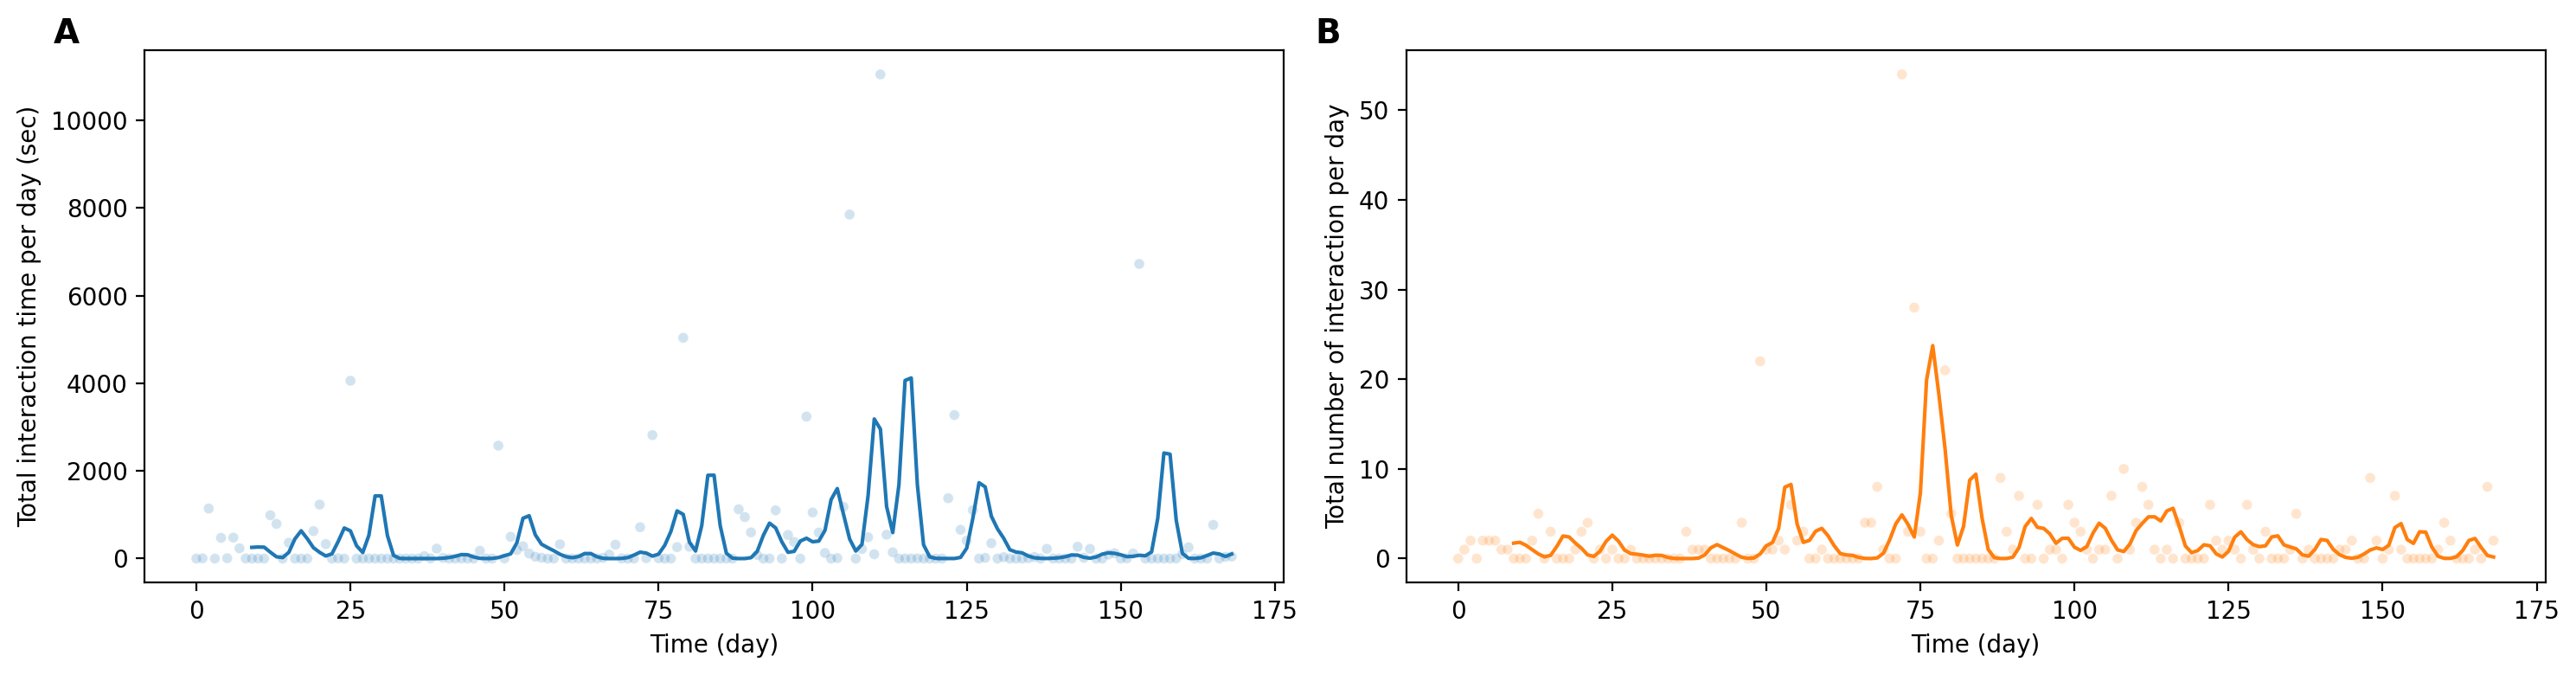

In [11]:
# fig, ax = plt.subplots()
# sns.histplot(ax=ax, data=df, x="day", kde=False, bins=30)
# ax.set_xlabel("Time (day)")
# ax.set_ylabel("Average number of interaction")
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))

ax = axes[0]

x = np.arange(n_days)
y = total_interaction_time_per_day

sns.scatterplot(ax=ax, x=x, y=y, size=1, alpha=0.2, legend=False)
pd.Series(y).rolling(10, win_type='gaussian').mean(std=1.0).plot(ax=ax)

ax.set_xlabel("Time (day)")
ax.set_ylabel("Total interaction time per day (sec)");

ax = axes[1]

x = np.arange(n_days)
y = number_interaction_per_day

sns.scatterplot(ax=ax, x=x, y=y, size=1, alpha=0.2, legend=False, color="C1")
pd.Series(y).rolling(10, win_type='gaussian').mean(std=1.0).plot(ax=ax, color="C1")

ax.set_xlabel("Time (day)")
ax.set_ylabel("Total number of interaction per day")

for ax, letter in zip(axes, string.ascii_uppercase):
    ax.text(-0.08, 1, letter, fontsize=14, fontweight="bold", va="bottom", ha="left",
           transform=ax.transAxes)
    
plt.tight_layout()
plt.savefig("fig/per_day.pdf")

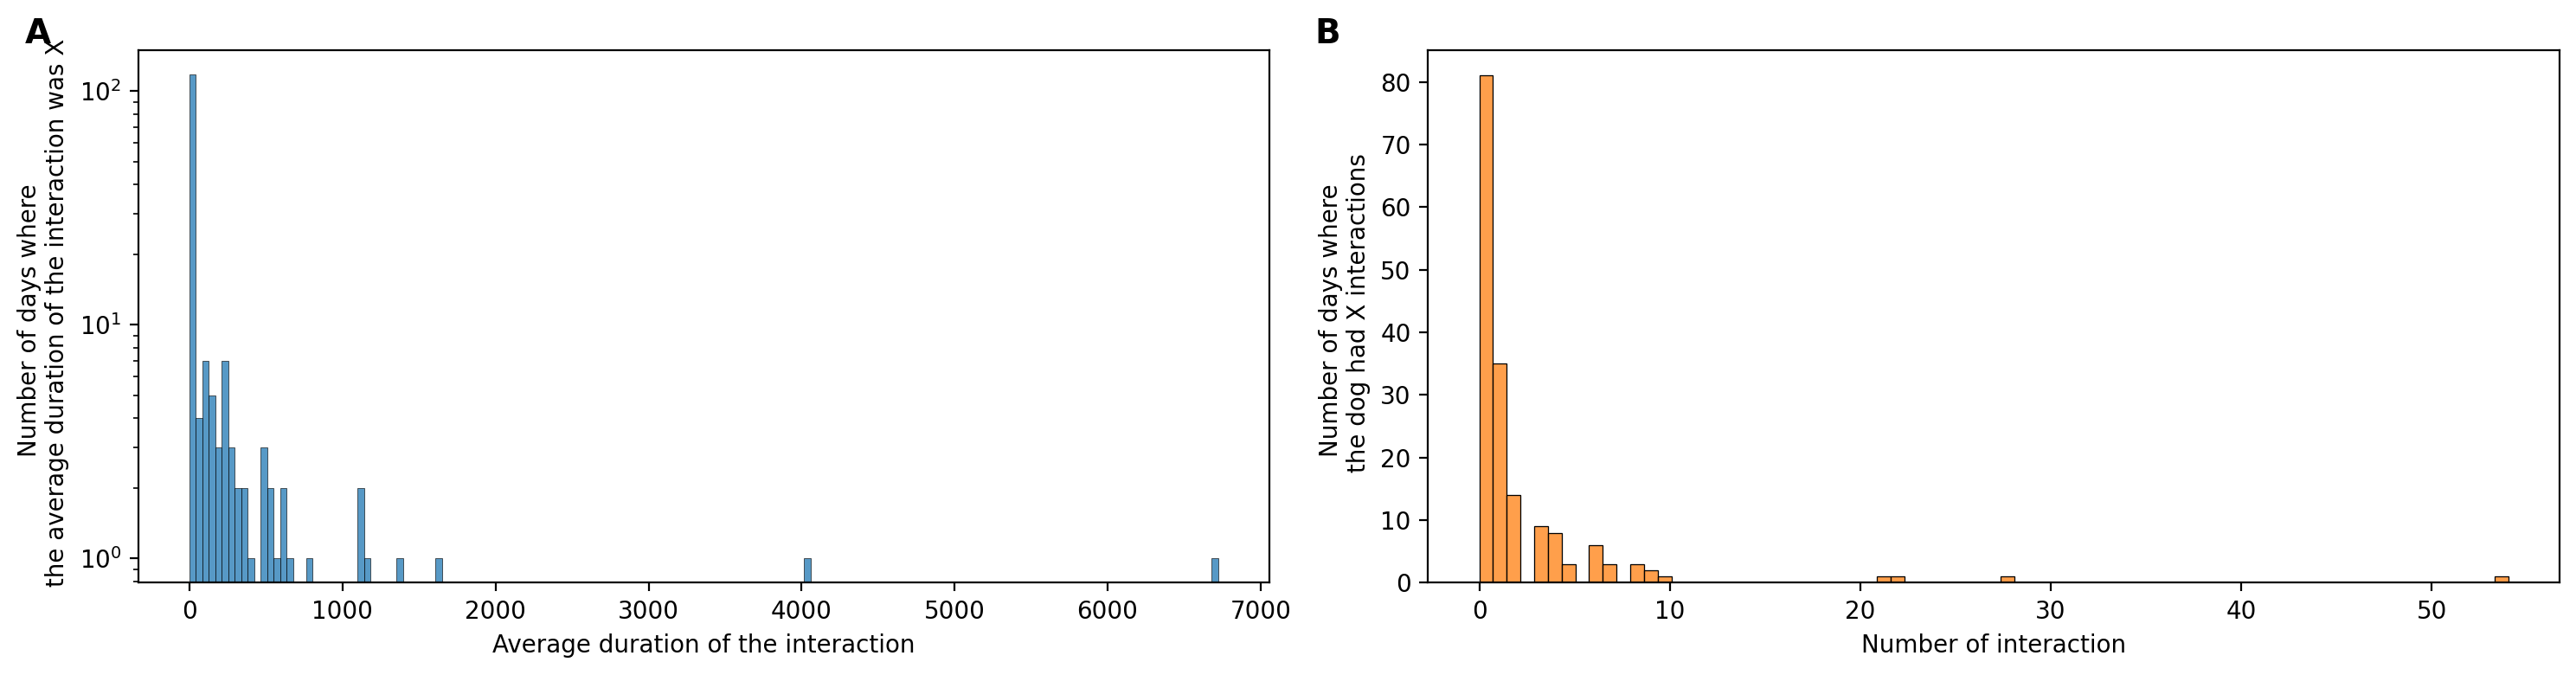

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))

ax = axes[0]

sns.histplot(ax=ax, x=average_interaction_time_per_day)
ax.set_yscale("log")
ax.set_xlabel("Average duration of the interaction")
ax.set_ylabel("Number of days where \n the average duration of the interaction was X");

ax = axes[1]

x = number_interaction_per_day
sns.histplot(ax=ax, x=x, color="C1")
ax.set_xlabel("Number of interaction")
ax.set_ylabel("Number of days where \n the dog had X interactions")

for ax, letter in zip(axes, string.ascii_uppercase):
    ax.text(-0.1, 1, letter, fontsize=14, fontweight="bold", va="bottom", ha="left",
           transform=ax.transAxes)
    
plt.tight_layout()
plt.savefig("fig/dist.pdf")

In [13]:
# fig, ax = plt.subplots(figsize=(15, 5))
# import datetime as dt
# from matplotlib import dates
# x = []
# for index, datetime in enumerate(df.datetime):
#     x.append(dt.datetime.combine(dt.date(2017, 1, 1), datetime.time()))
# sns.histplot(ax=ax, x=x, kde=False, bins=30)
# ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M:%S'))
# ax.set_ylabel("Number of interaction");

In [14]:
# df.groupby(df["datetime"].dt.hour)["seconds"].count().plot.bar();

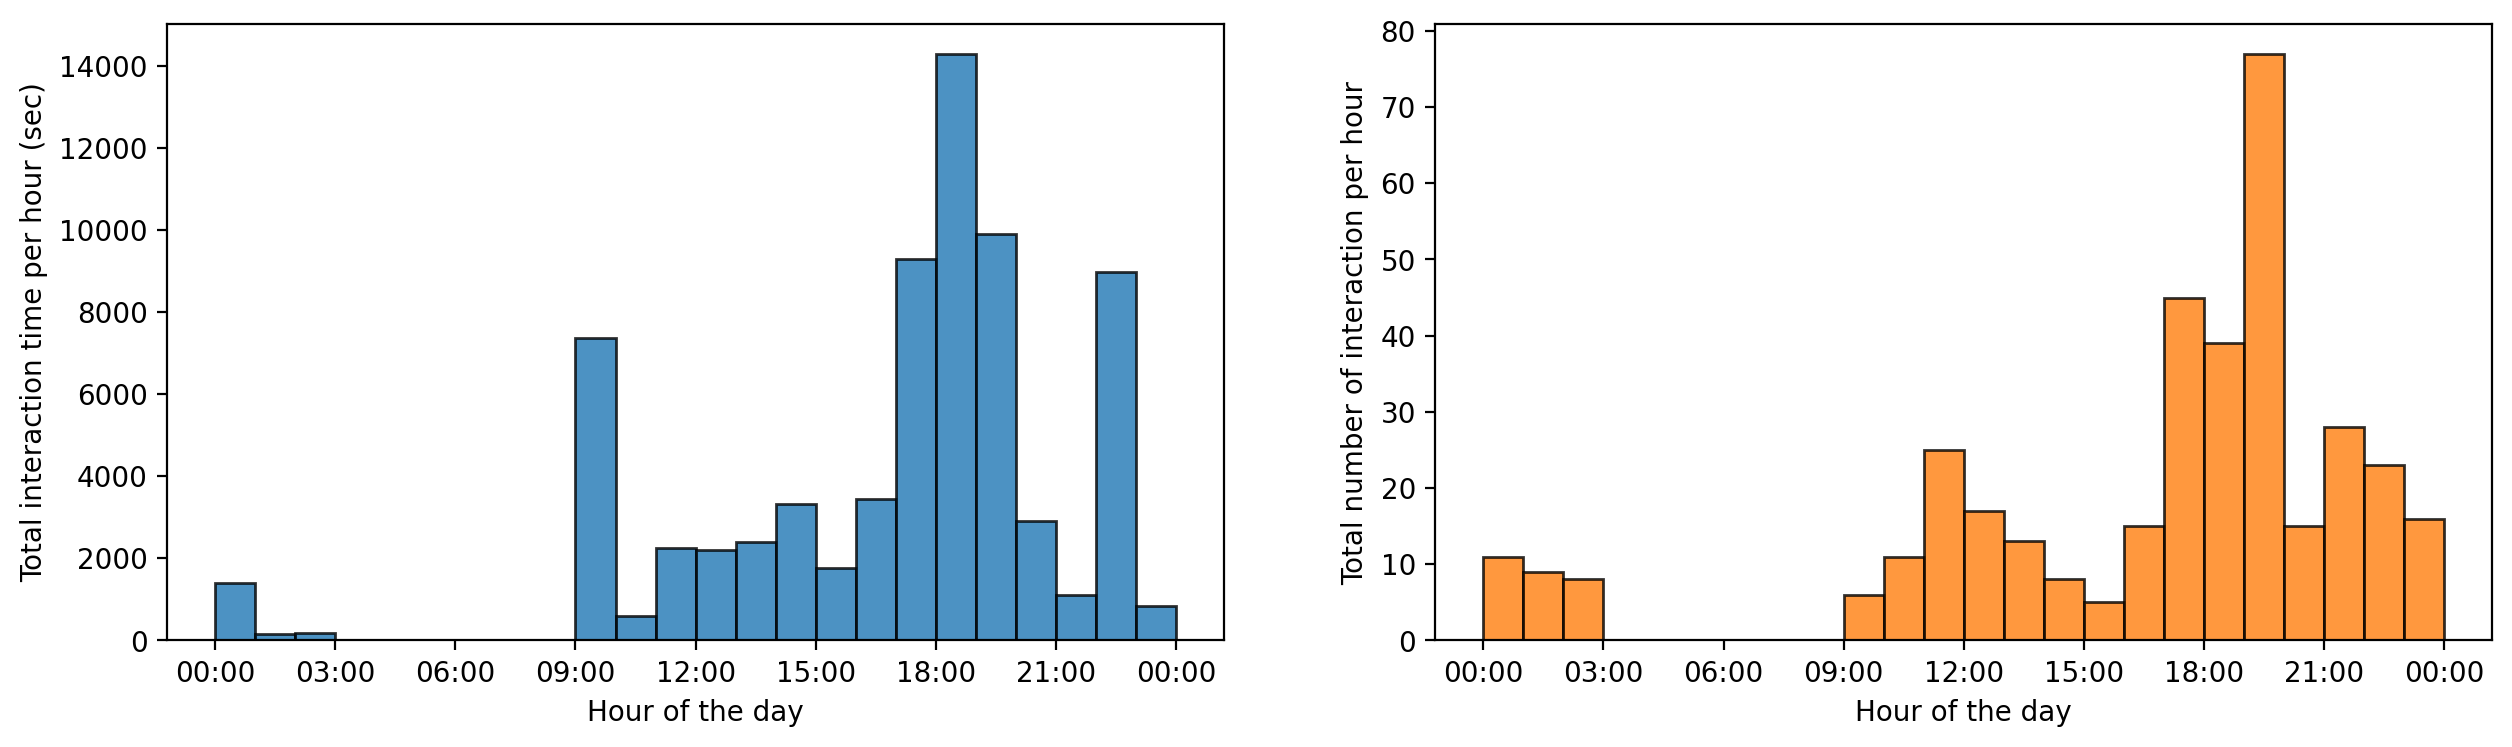

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))

ax = axes[0]

ts = [datetime(9999, 1, 1, i) for i in range(24)]

y__ = df.groupby(df["datetime"].dt.hour)["seconds"].sum()

y = np.zeros(24)
y[y__.index] = y__.values

# y_sem = np.zeros(24)
# y_sem[y__.index] = y__["sem"].values 

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.bar(x=ts, height=y, width=timedelta(hours=1), align='edge', edgecolor='black', alpha=0.8, color='C0')
       # yerr=y_sem);
ax.set_xlabel("Hour of the day")
ax.set_ylabel("Total interaction time per hour (sec)")

# ------------ #

ax = axes[1]

y__ = df.groupby(df["datetime"].dt.hour)["seconds"].count()

y = np.zeros(24)
y[y__.index] = y__.values 

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.bar(x=ts, height=y, width=timedelta(hours=1), align='edge', edgecolor='black', alpha=0.8, color="C1")

ax.set_xlabel("Hour of the day")
ax.set_ylabel("Total number of interaction per hour");

In [16]:
df["hour"] = df.datetime.dt.hour

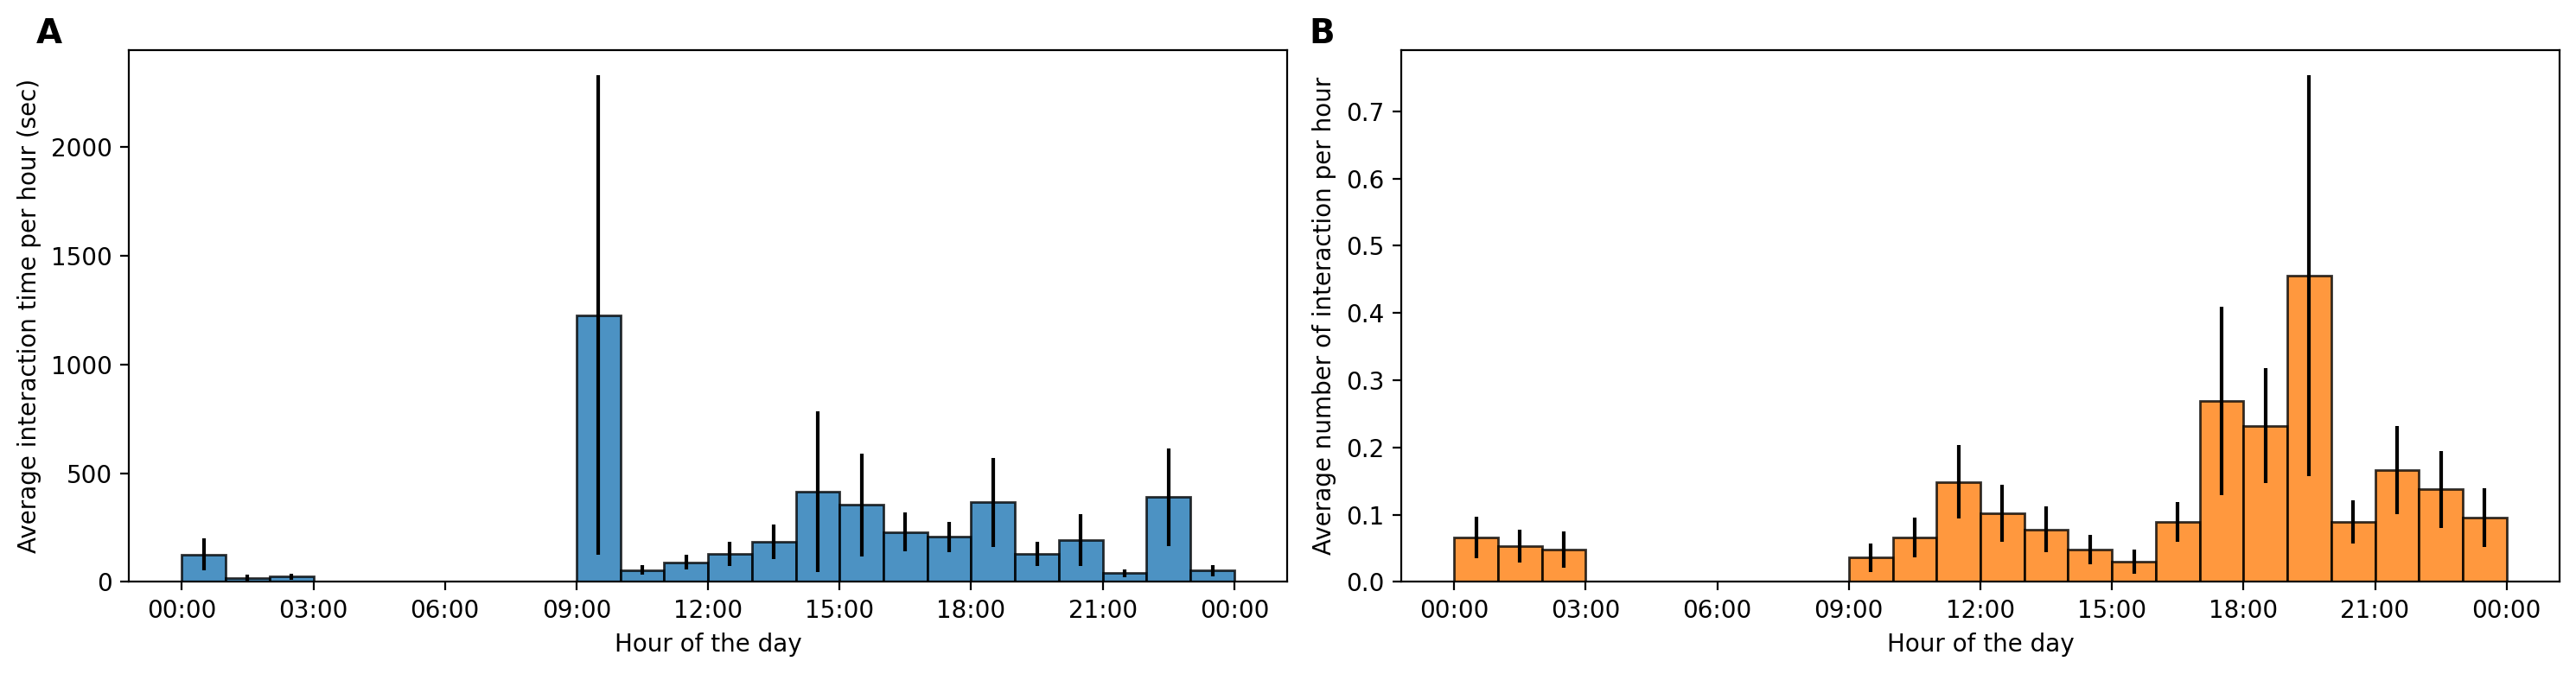

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))

ax = axes[0]

ts = [datetime(9999, 1, 1, i) for i in range(24)]

y__ = df.groupby(df["datetime"].dt.hour)["seconds"].agg([np.mean, sem])

y = np.zeros(24)
y[y__.index] = y__["mean"].values

y_sem = np.zeros(24)
y_sem[y__.index] = y__["sem"].values 

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.bar(x=ts, height=y, width=timedelta(hours=1), align='edge', edgecolor='black', alpha=0.8, color='C0',
       yerr=y_sem)
ax.set_xlabel("Hour of the day")
ax.set_ylabel("Average interaction time per hour (sec)")

# ------------ #

ax = axes[1]

df_count = pd.DataFrame(df.groupby(["day", "hour"])["seconds"].count())
df_count.rename(columns={"seconds": "n_interaction"}, inplace=True)
df_count.reset_index(inplace=True)

to_add = []
for day in range(1, df.day.max()):
    for hour in range(24):
        if not len(df_count[(df_count.day == day) & (df_count.hour == hour)].index):
            to_add.append({"day": day, "hour": hour, "n_interaction": 0})
    
df_count = pd.concat((df_count, pd.DataFrame(to_add)))
df_count.sort_values(["day", "hour"], inplace=True)

y__ = df_count.groupby("hour")["n_interaction"].agg([np.mean, sem])

y = np.zeros(24)
y[y__.index] = y__["mean"].values 

y_sem = np.zeros(24)
y_sem[y__.index] = y__["sem"].values 

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.bar(x=ts, height=y, width=timedelta(hours=1), align='edge', edgecolor='black', alpha=0.8, color="C1",
       yerr=y_sem)

ax.set_xlabel("Hour of the day")
ax.set_ylabel("Average number of interaction per hour")

for ax, letter in zip(axes, string.ascii_uppercase):
    ax.text(-0.08, 1, letter, fontsize=14, fontweight="bold", va="bottom", ha="left",
           transform=ax.transAxes)

plt.tight_layout()
plt.savefig("fig/per_hour.pdf")

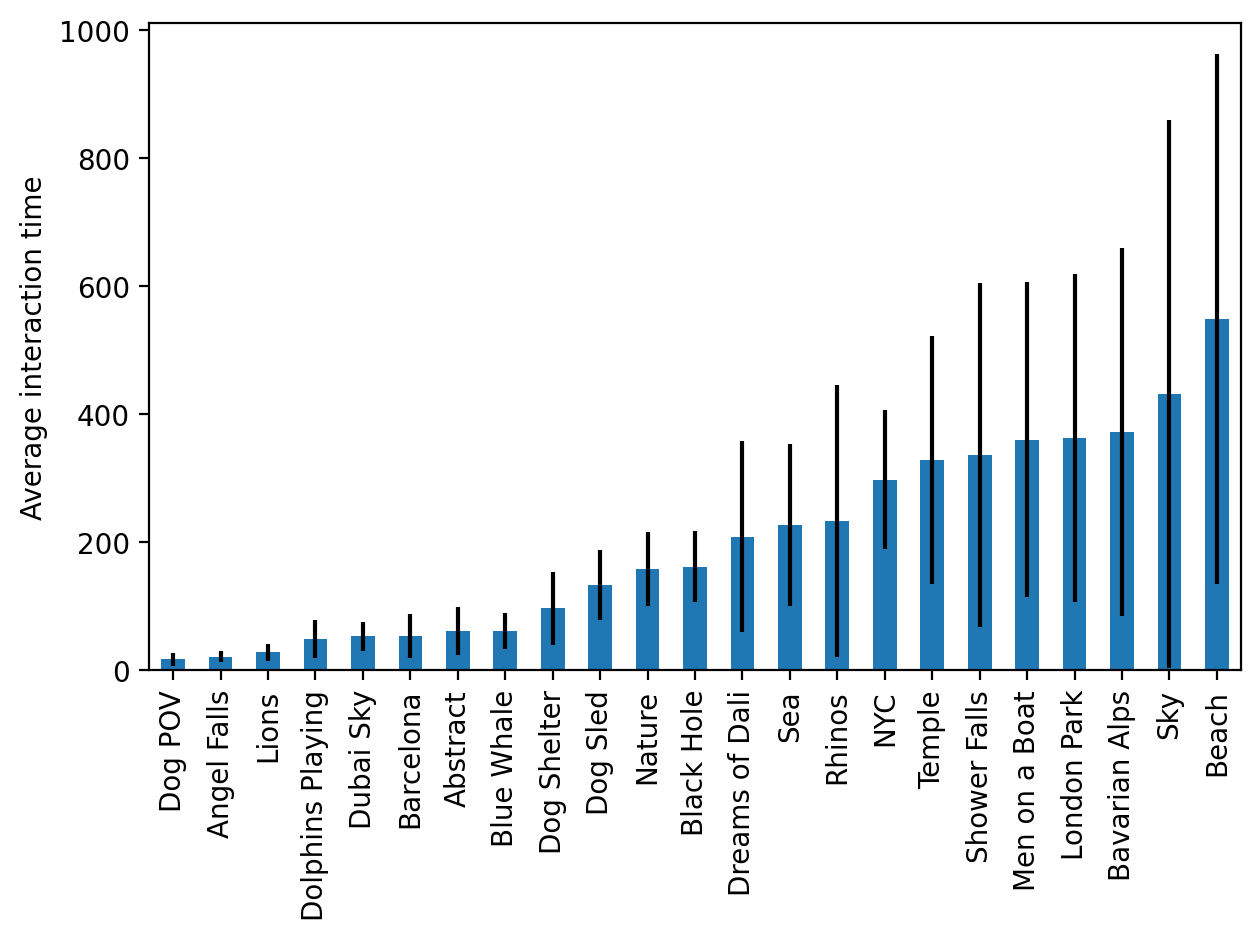

In [18]:
# ax = df.groupby('video')['seconds'].mean().sort_values().plot.bar()
# ax.set_xlabel("")
# ax.set_ylabel("Average duration of the interaction (sec)")
fig, ax = plt.subplots()

avg = df.groupby("video")["seconds"].agg([np.mean, sem])
avg = avg.sort_values("mean")
avg.plot(kind = "bar", y = "mean", ylabel="seconds", legend = False,
          yerr = "sem", ax=ax)

ax.set_xlabel("")
ax.set_ylabel("Average interaction time")

plt.tight_layout()

plt.savefig("fig/all_video.pdf")

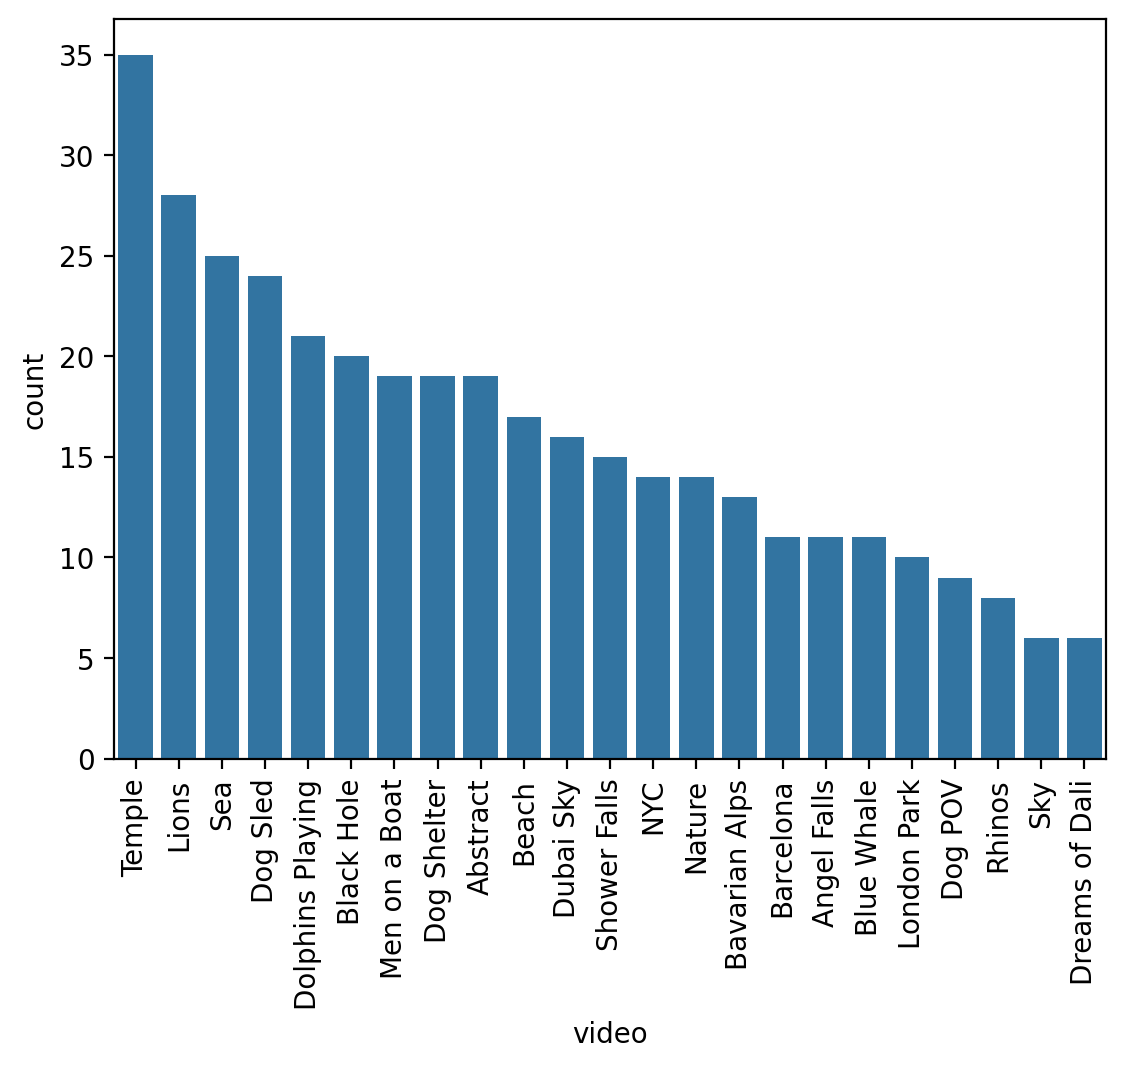

In [19]:
fig, ax = plt.subplots()
# sns.histplot(ax=ax, data=df, x="video")
sns.countplot(x = 'video',
              data = df,
              order = df['video'].value_counts().index, color="C0")
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [20]:
label_categories = df_labels.columns.to_list()[1:]
label_categories

['camera_movement', 'content_movement', 'color', 'content_type']

In [21]:
df_labels[df_labels["video"]== "Dubai Sky"]["camera_movement"].values[0]

'fast'

In [22]:
for index, row in df.iterrows():
    for cat in label_categories:
        label = df_labels[df_labels["video"] == row.video][cat].values[0]
        df.loc[index, cat] = label

In [23]:
df

,day,datetime,seconds,video,hour,camera_movement,content_movement,color,content_type
0,0,2021-08-14 11:02:20,6,Dubai Sky,11,fast,slow,static,sky
1,0,2021-08-14 19:41:28,41,Abstract,19,fast,fast,changing,abstract
2,2,2021-08-16 11:08:39,5,Dog POV,11,fast,fast,changing,animal
3,3,2021-08-17 11:49:42,642,Black Hole,11,slow,slow,static,abstract
4,3,2021-08-17 19:16:06,500,Men on a Boat,19,medium,medium,changing,water
...,...,...,...,...,...,...,...,...,...
366,168,2022-02-19 19:54:34,2,Abstract,19,fast,fast,changing,abstract
367,168,2022-02-19 19:56:38,10,Beach,19,slow,slow,static,nature
368,168,2022-02-19 20:05:50,6,Temple,20,slow,medium,changing,nature
369,168,2022-02-19 21:13:47,8,Shower Falls,21,still,fast,static,nature


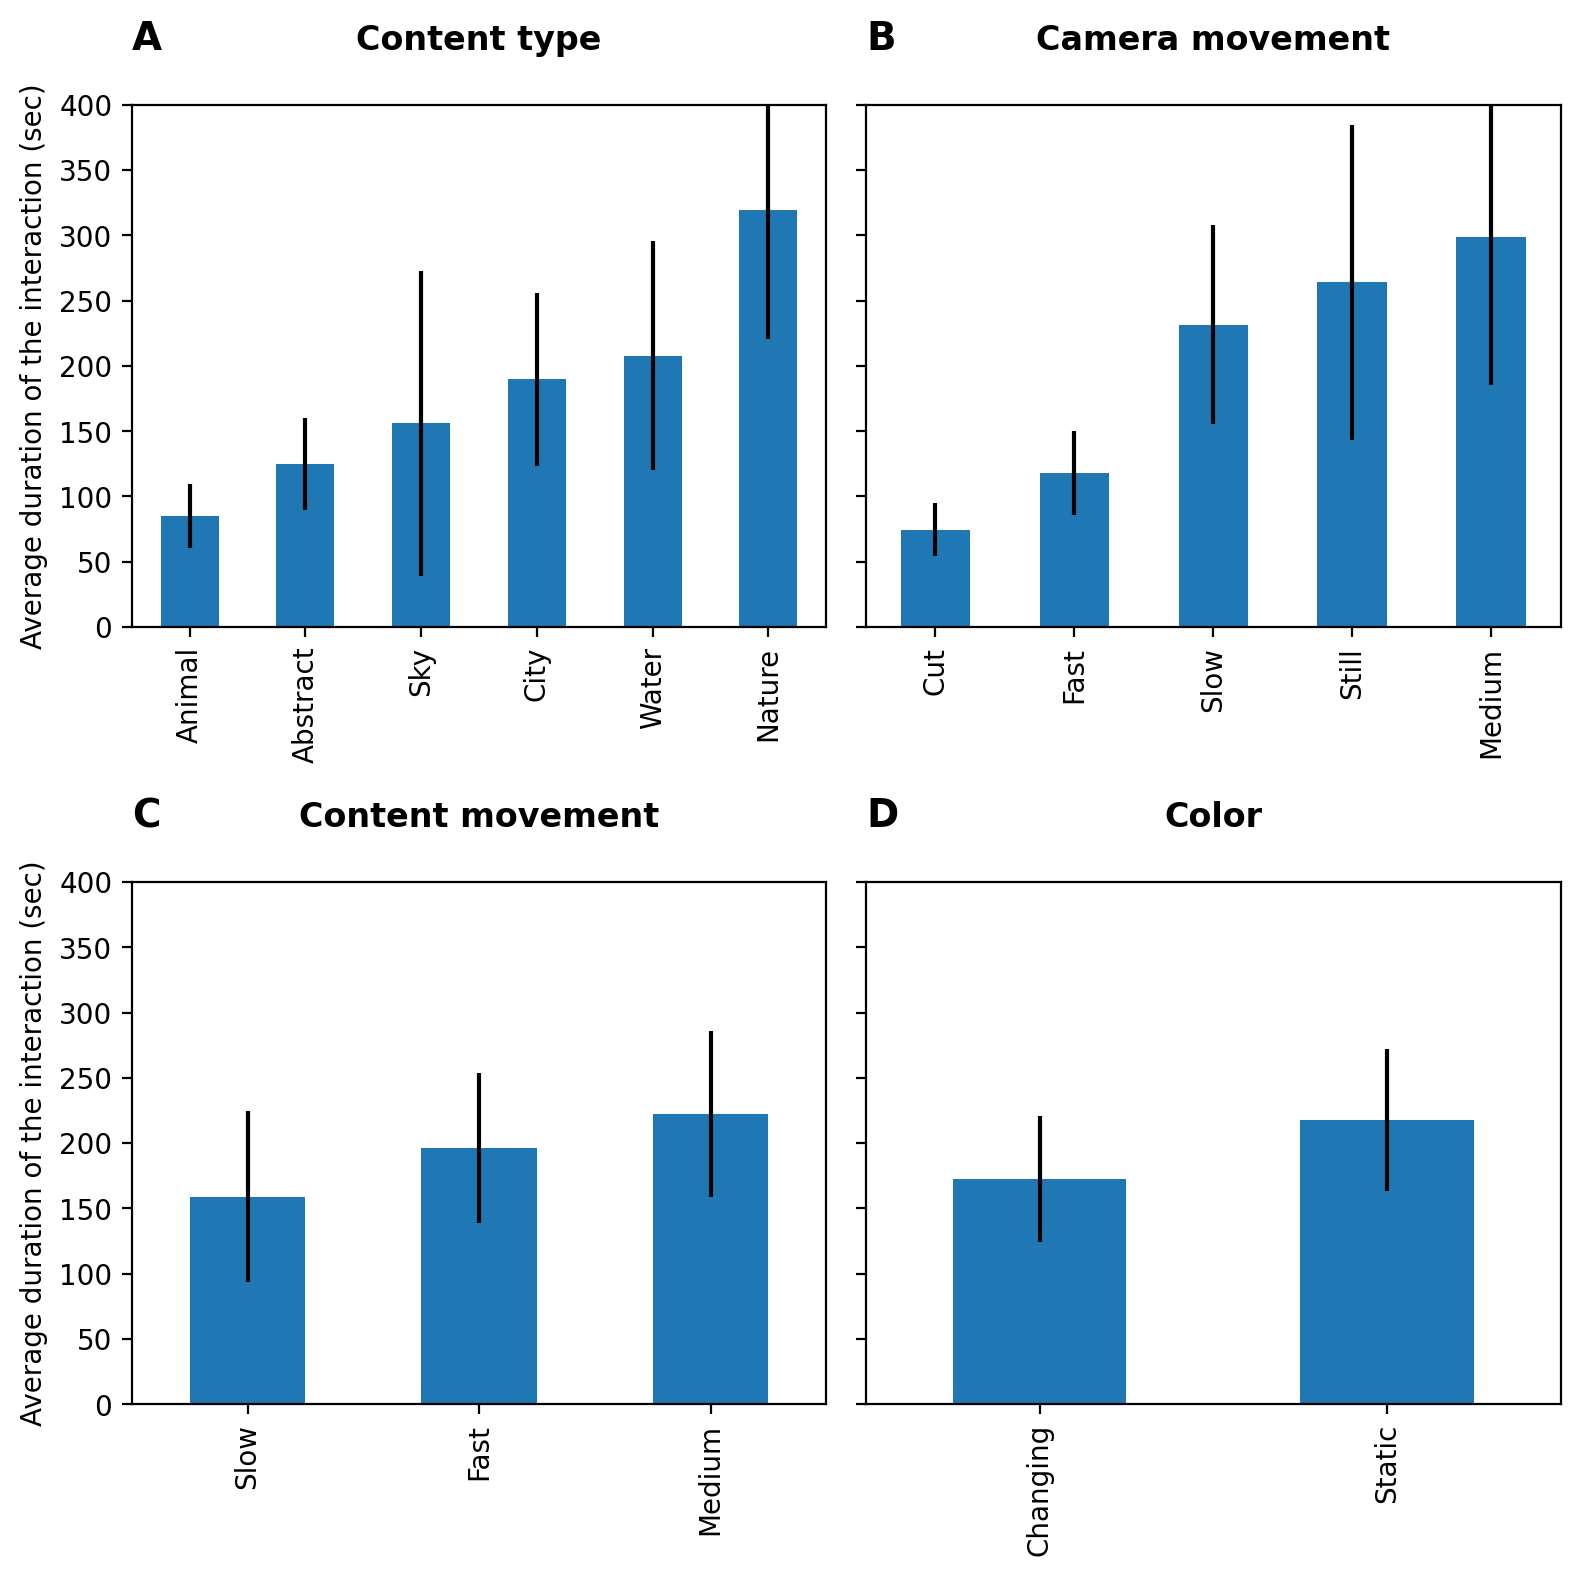

In [24]:
df_disp = copy.deepcopy(df)
for label in label_categories:
    df_disp[label] = df_disp[label].apply(lambda x: x.capitalize())

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
axes = axes.flatten()

label_categories.remove("content_type")
label_categories.insert(0, "content_type")

for i, cat in enumerate(label_categories):
    ax = axes[i] 
    qual = df_disp.groupby(cat)["seconds"].agg([np.mean, sem])
    qual = qual.sort_values("mean")
    qual.plot(kind = "bar", y = "mean", ylabel="seconds", legend = False,
              yerr = "sem", ax=ax)
    
    feature_name = cat.replace("_", " ").capitalize() + "\n"
    ax.set_title(feature_name, fontweight='bold')
    ax.set_xlabel("")
    if i % 2 == 0:
        ax.set_ylabel("Average duration of the interaction (sec)")
    else:
        ax.set_yticklabels("")
        ax.set_ylabel("")
    ax.set_ylim(0, 400)

for ax, letter in zip(axes, string.ascii_uppercase):
    if i % 2 == 0:
        lat_pos = - 0.08    
    else:
        lat_pos = - 0.0    
        
    ax.text(lat_pos, 1.09, letter, fontsize=14, fontweight="bold", va="bottom", ha="left",
            transform=ax.transAxes)

plt.tight_layout()

plt.savefig("fig/features.pdf")

In [25]:
cat = "color"
modalities = "changing", "static"
x1 = df[df[cat] == modalities[0]].seconds.values
x2 = df[df[cat] == modalities[1]].seconds.values
# print(f"N={len(x1) + len(x2) } ({len(x1)} + {len(x2)})")
u, p = mannwhitneyu(x1, x2)
n = len(x1) + len(x2)
print(f"$U={u}$, $p={p:.4f}$, $N={len(x1) + len(x2)}$")

$U=16093.5$, $p=0.2810$, $N=371$


In [26]:
cat = "content_movement"
modalities = "medium", "slow"
x1 = df[df[cat] == modalities[0]].seconds.values
x2 = df[df[cat] == modalities[1]].seconds.values
# print(f"N={len(x1) + len(x2) } ({len(x1)} + {len(x2)})")
u, p = mannwhitneyu(x1, x2)
n = len(x1) + len(x2)
print(f"$U={u}$, $p={p:.4f}$, $N={len(x1) + len(x2)}$")

$U=8703.5$, $p=0.4885$, $N=260$


In [27]:
cat = "camera_movement"
modalities = "cut", "medium"
x1 = df[df[cat] == modalities[0]].seconds.values
x2 = df[df[cat] == modalities[1]].seconds.values
# print(f"N={len(x1) + len(x2) } ({len(x1)} + {len(x2)})")
u, p = mannwhitneyu(x1, x2)
n = len(x1) + len(x2)
print(f"$U={u}$, $p={p:.4f}$, $N={len(x1) + len(x2)}$")

$U=1744.5$, $p=0.3255$, $N=126$


In [28]:
cat = "content_type"
modalities = "animal", "nature"
x1 = df[df[cat] == modalities[0]].seconds.values
x2 = df[df[cat] == modalities[1]].seconds.values
# print(f"N={len(x1) + len(x2) } ({len(x1)} + {len(x2)})")
u, p = mannwhitneyu(x1, x2)
n = len(x1) + len(x2)
print(f"$U={u}$, $p={p:.4f}$, $N={len(x1) + len(x2)}$")

$U=5070.5$, $p=0.1680$, $N=214$


In [32]:
cat = "video"
modalities = "Beach", "Dog POV"
x1 = df[df[cat] == modalities[0]].seconds.values
x2 = df[df[cat] == modalities[1]].seconds.values
# print(f"N={len(x1) + len(x2) } ({len(x1)} + {len(x2)})")
u, p = mannwhitneyu(x1, x2)
n = len(x1) + len(x2)
print(f"$U={u}$, $p={p:.4f}$, $N={len(x1) + len(x2)}$")

$U=100.0$, $p=0.2138$, $N=26$


In [33]:
cat = "video"
modalities = "Beach", "Angel Falls"
x1 = df[df[cat] == modalities[0]].seconds.values
x2 = df[df[cat] == modalities[1]].seconds.values
# print(f"N={len(x1) + len(x2) } ({len(x1)} + {len(x2)})")
u, p = mannwhitneyu(x1, x2)
n = len(x1) + len(x2)
print(f"$U={u}$, $p={p:.4f}$, $N={len(x1) + len(x2)}$")

$U=113.5$, $p=0.3574$, $N=28$


In [34]:
cat = "video"
modalities = "Lions", "Temple"
x1 = df[df[cat] == modalities[0]].seconds.values
x2 = df[df[cat] == modalities[1]].seconds.values
# print("n", len(x1), len(x2))
u, p = mannwhitneyu(x1, x2)
n = len(x1) + len(x2)
print(f"$U={u}$, $p={p:.4f}$, $N={len(x1) + len(x2)}$")

$U=410.5$, $p=0.2729$, $N=63$


In [35]:
df.seconds.mean()

195.3099730458221

In [36]:
df.seconds.min()

1

In [37]:
df.seconds.max()

7118

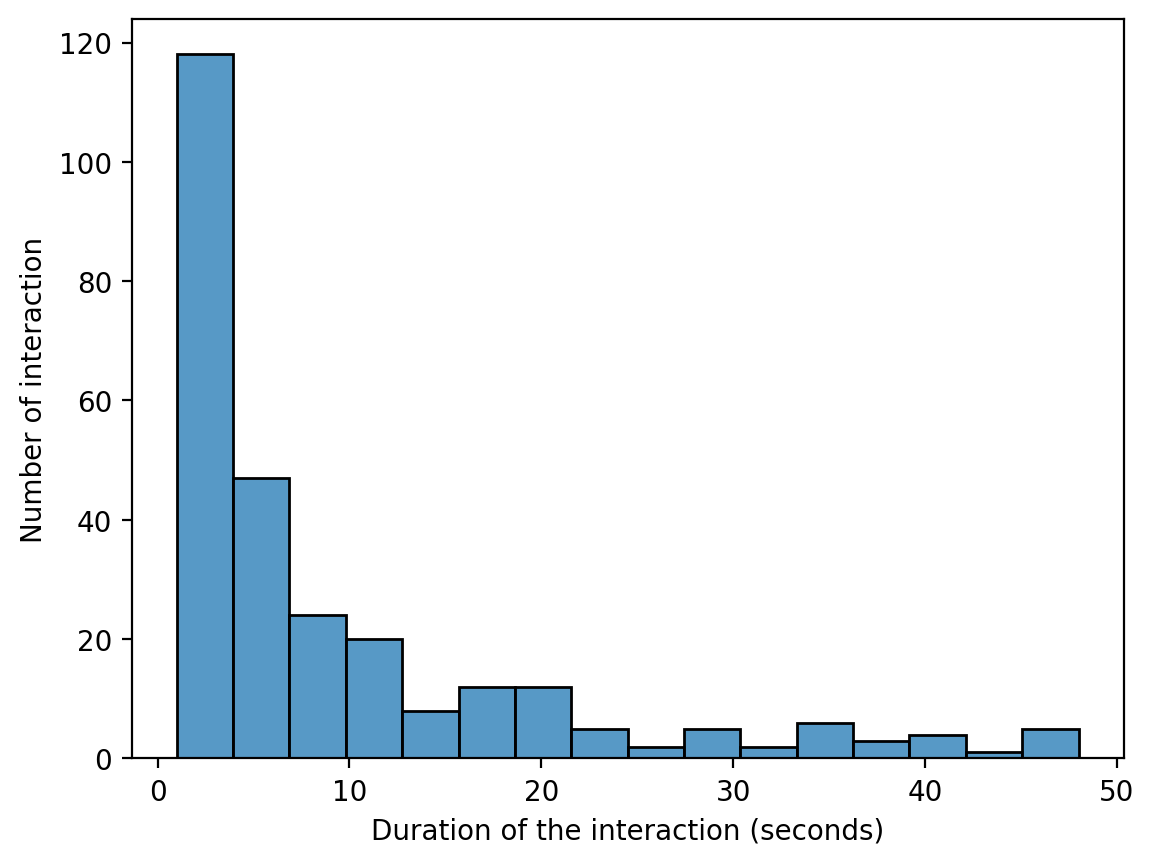

In [39]:
fig, ax = plt.subplots()
sns.histplot(ax=ax, x=df.seconds[df.seconds < 50])
ax.set_xlabel("Duration of the interaction (seconds)")
ax.set_ylabel("Number of interaction");

In [40]:
df_traces = pd.read_csv("traces/traces.csv", index_col=0)
df_traces

,cat,err,learning
0,camera_movement,6.378905,before
1,camera_movement,5.231117,after
2,camera_movement,15.782639,before
3,camera_movement,11.592491,after
4,camera_movement,13.430036,before
...,...,...,...
155,content_type,8.141918,after
156,content_type,7.488688,before
157,content_type,5.389960,after
158,content_type,20.293980,before


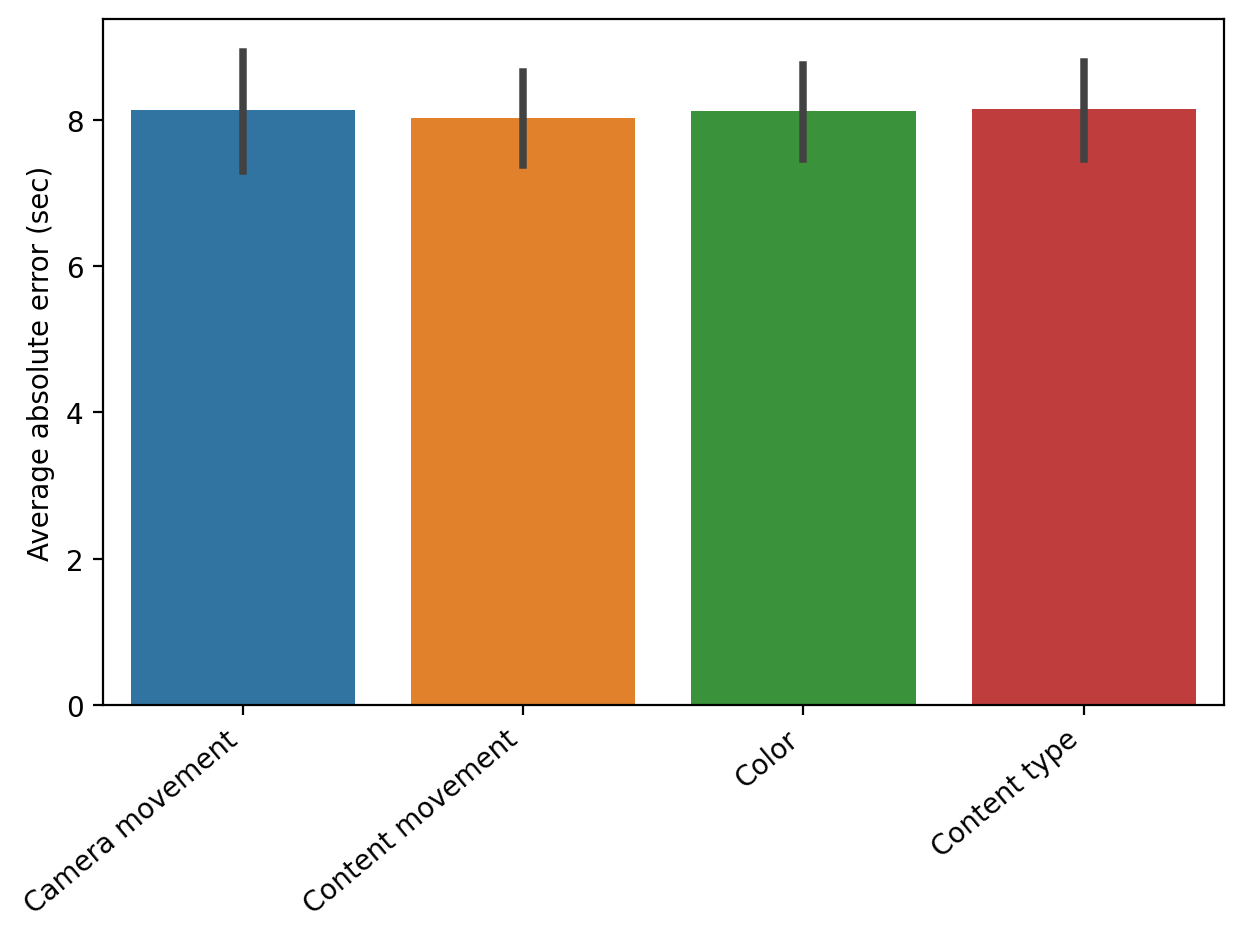

In [41]:
fig, ax = plt.subplots()
sns.barplot(ax=ax, x="cat", y="err", data=df_traces[df_traces.learning == "after"])
labels = [v.get_text() for v in ax.get_xticklabels()]  # get the position and text for each subplot
labels = [v.replace("_", " ").capitalize() for v in labels]

ax.set_ylabel("Average absolute error (sec)")
ax.set_xlabel("")

ax.set_xticklabels(labels, rotation=40, ha="right")

plt.tight_layout()

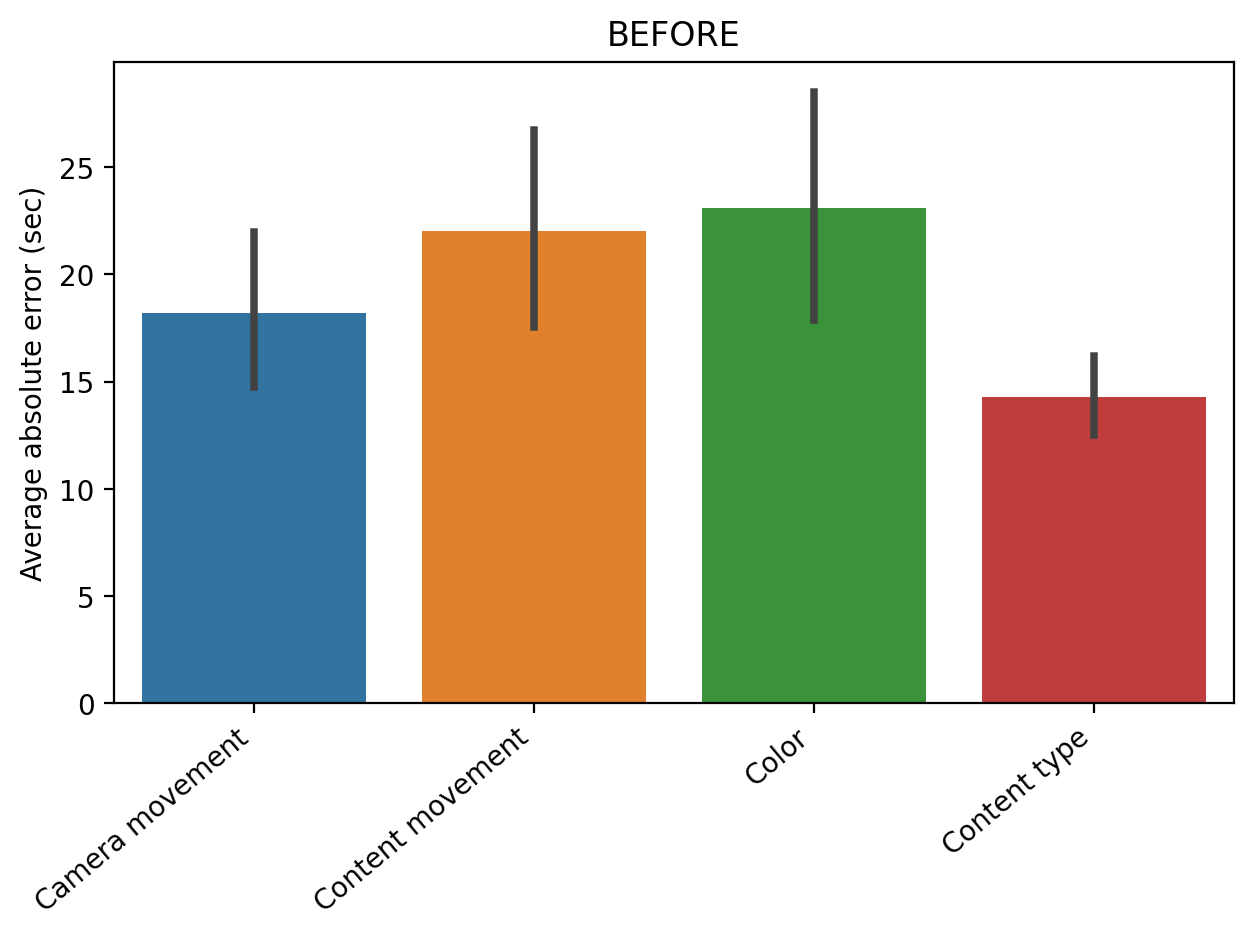

In [42]:
fig, ax = plt.subplots()
sns.barplot(ax=ax, x="cat", y="err", data=df_traces[df_traces.learning == "before"])
labels = [v.get_text() for v in ax.get_xticklabels()]  # get the position and text for each subplot
labels = [v.replace("_", " ").capitalize() for v in labels]

ax.set_ylabel("Average absolute error (sec)")

ax.set_xticklabels(labels, rotation=40, ha="right")

ax.set_title("BEFORE")
ax.set_xlabel("")

plt.tight_layout()

In [43]:
model_lin = sm.OLS.from_formula("seconds ~ camera_movement + content_movement + content_type + color", 
                                data=df)
result_lin = model_lin.fit()
result_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                seconds   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.7997
Date:                Sat, 10 Sep 2022   Prob (F-statistic):              0.651
Time:                        12:38:11   Log-Likelihood:                -2950.9
No. Observations:                 371   AIC:                             5928.
Df Residuals:                     358   BIC:                             5979.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     61.9870    224.868      0.276      0.783    -380.241     504.215
camera_movement[T.fast]       28.8121    184.644      0.156      0.876    -334.311     391.935
camera_movement[T.medium]    292.8928    212.797      1.376      0.170    -125.597     711.383
camera_movement[T.slow]      136.2327    158.382      0.860      0.390    -175.244     447.709
camera_movement[T.still]     143.5405    235.871      0.609      0.543    -320.326     607.407
content_movement[T.medium]   -14.4705    130.750     -0.111      0.912    -271.605     242.664
content_movement[T.slow]     -14.0441    139.924     -0.100      0.920    -289.221     261.133
content_type[T.animal]       -27.6794    157.170     -0.176      0.860    -336.772     281.414
content_type[T.city]         118.1252    199.384      0.592      0.554    -273.986     510.236
content_type[T.nature]       137.9609    151.386      0.911      0.363    -159.756     435.678
content_type[T.sky]           53.3169    186.539      0.286      0.775    -313.533     420.167
content_type[T.water]        -74.7661    196.396     -0.381      0.704    -461.001     311.469
color[T.static]              -10.0857    107.549     -0.094      0.925    -221.592     201.421
==============================================================================
Omnibus:                      497.530   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45724.130
Skew:                           6.651   Prob(JB):                         0.00
Kurtosis:                      55.735   Cond. No.                         16.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
model_lin = sm.OLS.from_formula("seconds ~ camera_movement*content_movement*content_type*color", 
                                data=df)
result_lin = model_lin.fit()
result_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                seconds   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.7730
Date:                Sat, 10 Sep 2022   Prob (F-statistic):              0.753
Time:                        12:38:12   Log-Likelihood:                -2947.4
No. Observations:                 371   AIC:                             5939.
Df Residuals:                     349   BIC:                             6025.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================================================
                                                                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                      81.8184     83.857      0.976      0.330     -83.111     246.748
camera_movement[T.fast]                                                                       -21.8184    104.518     -0.209      0.835    -227.382     183.746
camera_movement[T.medium]                                                                      50.2398     35.608      1.411      0.159     -19.793     120.272
camera_movement[T.slow]                                                                        64.7356     80.058      0.809      0.419     -92.722     222.193
camera_movement[T.still]                                                                        9.4050     35.081      0.268      0.789     -59.592      78.402
content_movement[T.medium]                                                                      6.7790     64.497      0.105      0.916    -120.073     133.631
content_movement[T.slow]                                                                      -17.6102     67.384     -0.261      0.794    -150.140     114.920
content_type[T.animal]                                                                        -29.3889    104.727     -0.281      0.779    -235.365     176.587
content_type[T.city]                                                                           67.2836    117.169      0.574      0.566    -163.162     297.729
content_type[T.nature]                                                                         78.4319     75.991      1.032      0.303     -71.025     227.889
content_type[T.sky]                                                                           122.6192    102.911      1.192      0.234     -79.785     325.023
content_type[T.water]                                                                          29.6271     34.541      0.858      0.392     -38.307      97.561
color[T.static]                                                                                26.6942     48.690      0.548      0.584     -69.069     122.457
camera_movement[T.fast]:content_movement[T.medium]                                          -1.205e-13   1.45e-13     -0.833      0.406   -4.05e-13    1.64e-13
camera_movement[T.medium]:content_movement[T.medium]                                           50.2398     35.608      1.411      0.159     -19.793     120.272
camera_movement[T.slow]:content_movement[T.medium]                                             22.6429     41.971      0.539      0.590     -59.906     105.192
camera_movement[T.still]:content_movement[T

$\rho=-0.1189$, $p=0.5890$, $N=23$


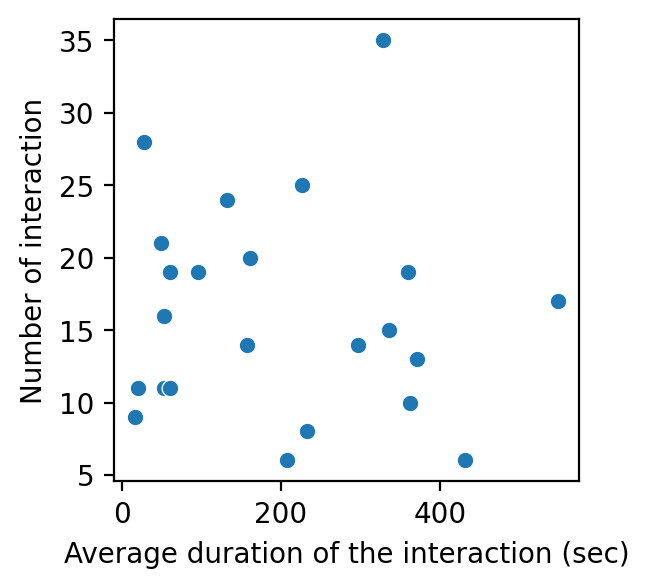

In [45]:
fig, ax = plt.subplots(figsize=(3, 3))

x = df.groupby('video')['seconds'].mean()
y = df['video'].value_counts()[x.index]

sns.scatterplot(x=x, y=y, ax=ax);
ax.set_xlabel("Average duration of the interaction (sec)")
ax.set_ylabel("Number of interaction")

plt.savefig("fig/familiarity.pdf")

corr, p = spearmanr(x, y)
print(f"$\\rho={corr:.4f}$, $p={p:.4f}$, $N={len(x)}$")

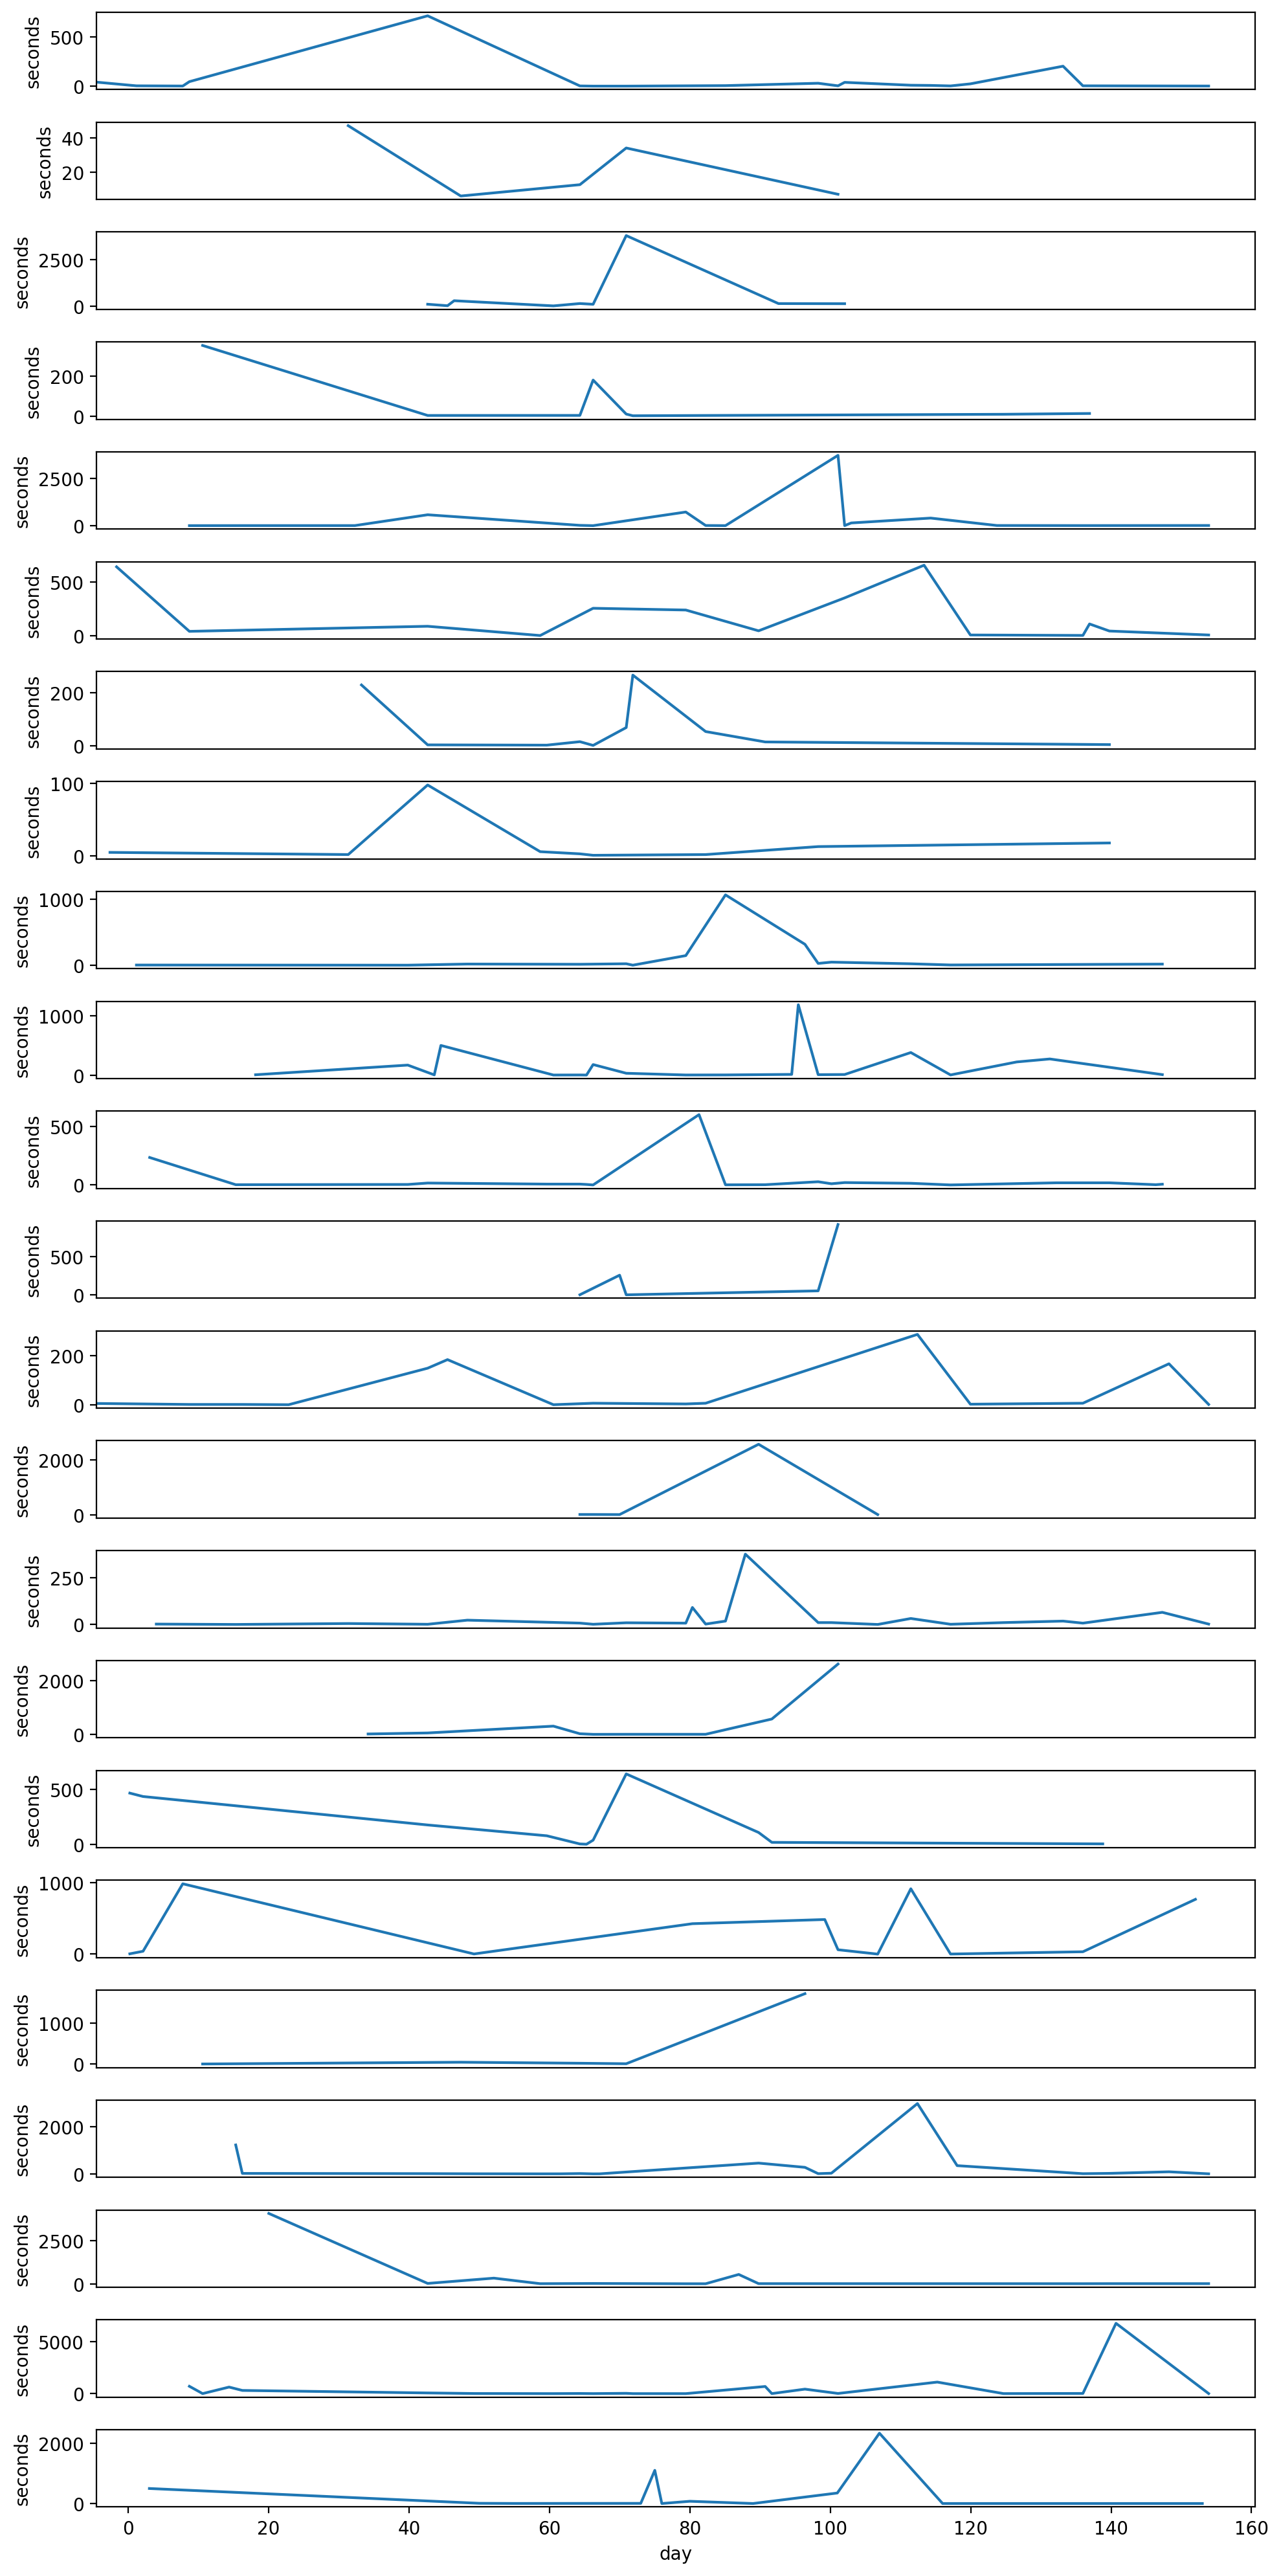

In [46]:
fig, axes = plt.subplots(nrows=n_video, figsize=(10, 20))

for i, video in enumerate(video_labels):
    
    ax = axes[i]
    sns.lineplot(data=df[df.video==video], y="seconds", x="day", legend=False, ax=ax, ci=None)

for ax in axes[:-1]:
    ax.set_xlim(0, 175)
    ax.set_xlabel("")
    ax.set_xticks([])
    
plt.tight_layout()

$\rho=0.8842$, $p=0.0000$, $N=169$


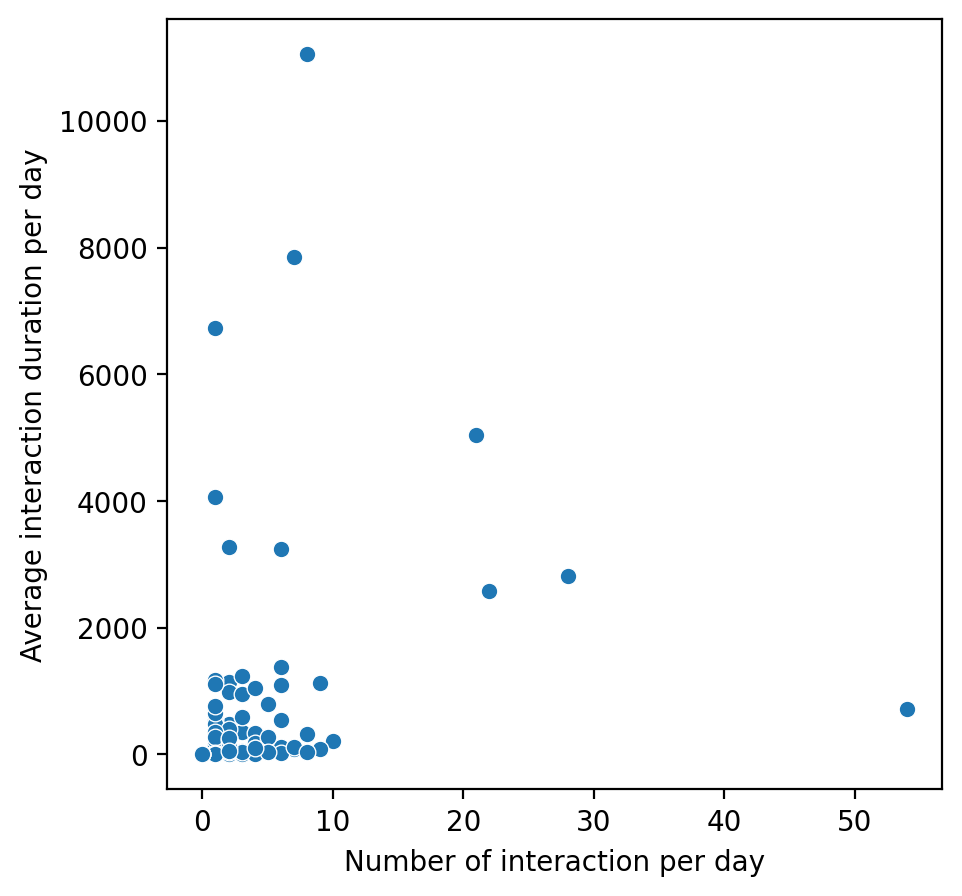

In [48]:
fig, ax = plt.subplots(figsize=(5, 5))

x = number_interaction_per_day
y = total_interaction_time_per_day

sns.scatterplot(x=x, y=y, ax=ax)
ax.set_xlabel("Number of interaction per day")
ax.set_ylabel("Average interaction duration per day")

n = len(x)
corr, p = spearmanr(x, y)
print(f"$\\rho={corr:.4f}$, $p={p:.4f}$, $N={len(x)}$")

In [49]:
x1 = number_interaction_per_day
x2 = SINGLE_number_interaction_per_day
u, p = mannwhitneyu(x1, x2)
n = len(x1) + len(x2)
print(f"{x1.mean():.2f}\pm {sem(x1):.2f} \
vs {x2.mean():.2f} \pm {sem(x2):.2f}", )
print(f"$U={u}$, $p={p:.4f}$, $N={len(x1) + len(x2)}$")

2.20\pm 0.42 vs 62.25 \pm 14.95
$U=8.5$, $p=0.0000$, $N=177$


In [50]:
x = number_interaction_per_day
f"{x.mean():.1f} & {np.median(x):.1f} & {sem(x):.1f} & {np.max(x):.1f} & {np.min(x):.1f}"

'2.2 & 1.0 & 0.4 & 54.0 & 0.0'

In [51]:
x = SINGLE_number_interaction_per_day
f"{x.mean():.1f} & {np.median(x):.1f} & {sem(x):.1f} & {np.max(x):.1f} & {np.min(x):.1f}"

'62.2 & 55.5 & 15.0 & 124.0 & 10.0'

In [52]:
x1 = total_interaction_time_per_day
x2 = SINGLE_total_interaction_time_per_day
u, p = mannwhitneyu(x1, x2)
n = len(x1) + len(x2)
print(f"{x1.mean():.2f}\pm {sem(x1):.2f} \
vs {x2.mean():.2f} \pm {sem(x2):.2f}", )
print(f"$U={u}$, $p={p:.4f}$, $N={len(x1) + len(x2)}$")

428.76\pm 101.88 vs 392.17 \pm 97.69
$U=306.0$, $p=0.0061$, $N=177$


In [53]:
x = total_interaction_time_per_day
f"{x.mean():.1f} & {np.median(x):.1f} & {sem(x):.1f} & {np.max(x):.1f} & {np.min(x):.1f}"

'428.8 & 3.0 & 101.9 & 11047.0 & 0.0'

In [54]:
x = SINGLE_total_interaction_time_per_day
f"{x.mean():.1f} & {np.median(x):.1f} & {sem(x):.1f} & {np.max(x):.1f} & {np.min(x):.1f}"

'392.2 & 382.9 & 97.7 & 832.0 & 44.0'

In [57]:
x1 = average_interaction_time_per_day
x2 = SINGLE_average_interaction_time_per_day
u, p = mannwhitneyu(x1, x2)
n = len(x1) + len(x2)
print(f"{x1.mean():.2f}\pm {sem(x1):.2f} \
vs {x2.mean():.2f} \pm {sem(x2):.2f}", )
print(f"$U={u}$, $p={p:.4f}$, $N={len(x1) + len(x2)}$")

176.87\pm 49.58 vs 6.19 \pm 0.48
$U=577.0$, $p=0.4645$, $N=177$


In [59]:
x2 = SINGLE_average_interaction_time_per_day

x1 = average_interaction_time_per_day[:len(x2)]

u, p = mannwhitneyu(x1, x2)
n = len(x1) + len(x2)
print(f"{x1.mean():.2f}\pm {sem(x1):.2f} \
vs {x2.mean():.2f} \pm {sem(x2):.2f}", )
print(f"$U={u}$, $p={p:.4f}$, $N={len(x1) + len(x2)}$")

161.19\pm 71.47 vs 6.19 \pm 0.48
$U=35.0$, $p=0.7927$, $N=16$


In [60]:
x2 = SINGLE_number_interaction_per_day[:len(x2)]
x1 = number_interaction_per_day

u, p = mannwhitneyu(x1, x2)
n = len(x1) + len(x2)
print(f"{x1.mean():.2f}\pm {sem(x1):.2f} \
vs {x2.mean():.2f} \pm {sem(x2):.2f}", )
print(f"$U={u}$, $p={p:.4f}$, $N={len(x1) + len(x2)}$")

2.20\pm 0.42 vs 62.25 \pm 14.95
$U=8.5$, $p=0.0000$, $N=177$
